VIABILITY PASS RATE ANALYSIS
Loading dataset from: ../data/bills_6congress_training.csv
Loaded 76897 bills

Loading trained models...
Models loaded successfully!

Preparing features...
Features prepared!

Calculating viability scores for all bills...
Processing bill 0/76897...
Processing bill 5000/76897...
Processing bill 10000/76897...
Processing bill 15000/76897...
Processing bill 20000/76897...
Processing bill 25000/76897...
Processing bill 30000/76897...
Processing bill 35000/76897...
Processing bill 40000/76897...
Processing bill 45000/76897...
Processing bill 50000/76897...
Processing bill 55000/76897...
Processing bill 60000/76897...
Processing bill 65000/76897...
Processing bill 70000/76897...
Processing bill 75000/76897...

Calculated viability scores for 76897 bills

ANALYZING PASS RATES BY VIABILITY SCORE
0-10%: 27,829 bills, 0 passed (0.0%)
10-20%: 19,116 bills, 2 passed (0.0%)
20-30%: 8,084 bills, 2 passed (0.0%)
30-40%: 4,673 bills, 10 passed (0.2%)
40-50%: 3,254 bills, 1

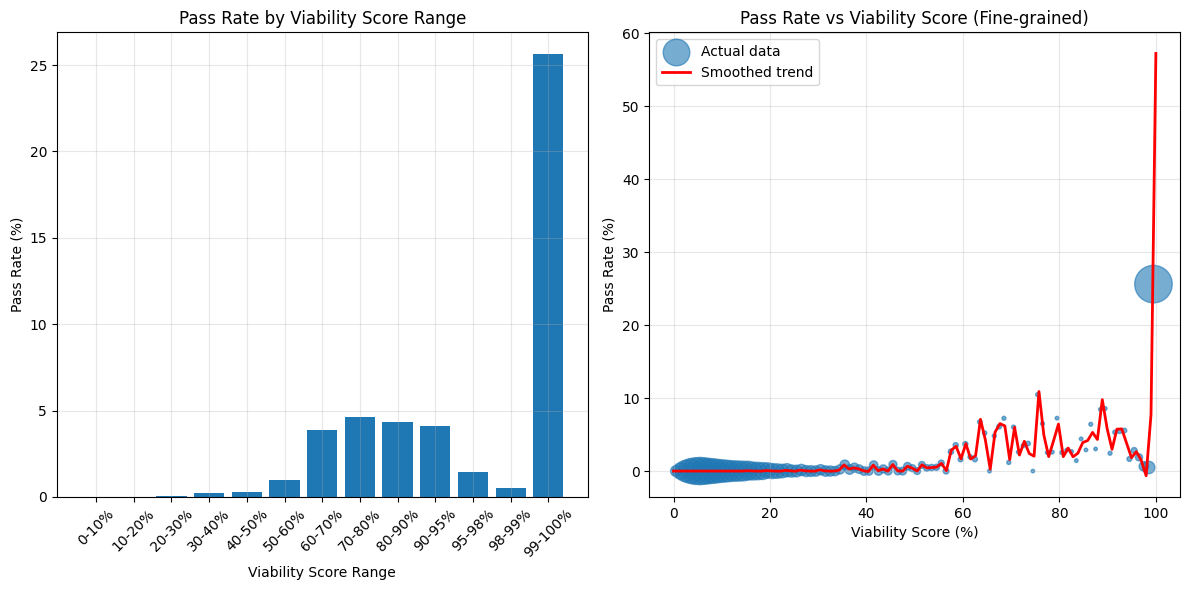

In [2]:
# VIABILITY PASS RATE ANALYZER
# Analyzes the training dataset to compute actual pass rates for different viability score ranges

import pandas as pd
import numpy as np
import joblib
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("VIABILITY PASS RATE ANALYSIS")
print("="*60)

# Load the training dataset
dataset_path = '../data/bills_6congress_training.csv'
print(f"Loading dataset from: {dataset_path}")
df = pd.read_csv(dataset_path)
print(f"Loaded {len(df)} bills")

# Load the trained models
print("\nLoading trained models...")
models_loaded = {}

# Load metadata and encoders
metadata_package = joblib.load('../models/metadata.pkl')
label_encoders = metadata_package['label_encoders']

# Function to load a model stage
def load_model_stage(model_type, stage):
    model_dir = f'../models/{model_type}_{stage}'
    
    # Load components
    rf_model = joblib.load(f'{model_dir}/rf_model.pkl')
    components = joblib.load(f'{model_dir}/components.pkl')
    
    return {
        'rf_model': rf_model,
        'gb_model': components['gb_model'],
        'lr_model': components['lr_model'],
        'scaler': components['scaler'],
        'selector': components['selector'],
        'features': components['metadata']['features'],
        'selected_features': components['metadata']['selected_features'],
        'threshold': components['metadata']['threshold']
    }

# Load all viability models
viability_models = {
    'new_bill': load_model_stage('viability', 'new_bill'),
    'early_stage': load_model_stage('viability', 'early_stage'),
    'progressive': load_model_stage('viability', 'progressive')
}

print("Models loaded successfully!")

# Feature engineering (same as training)
print("\nPreparing features...")

def safe_get_column(df, col_name, default_value):
    if col_name in df.columns:
        return df[col_name].fillna(default_value)
    else:
        return default_value

# Basic features
df['sponsor_party'] = safe_get_column(df, 'sponsor_party', 'Unknown')
df['policy_area'] = safe_get_column(df, 'policy_area', 'Unknown')

# Encode categorical variables
df['sponsor_party_encoded'] = 0
df['policy_area_encoded'] = 0

# Try to encode, but use 0 if unknown
for idx, party in enumerate(df['sponsor_party']):
    try:
        df.loc[idx, 'sponsor_party_encoded'] = label_encoders['party'].transform([party])[0]
    except:
        df.loc[idx, 'sponsor_party_encoded'] = 0

for idx, policy in enumerate(df['policy_area']):
    try:
        df.loc[idx, 'policy_area_encoded'] = label_encoders['policy'].transform([policy])[0]
    except:
        df.loc[idx, 'policy_area_encoded'] = 0

# Time features
if 'days_active' not in df.columns:
    df['days_active'] = 30

df['action_count'] = safe_get_column(df, 'action_count', 1).clip(1, 100)
df['committee_count'] = safe_get_column(df, 'committee_count', 0)
df['cosponsor_count'] = safe_get_column(df, 'cosponsor_count', 0)
df['original_cosponsor_count'] = safe_get_column(df, 'original_cosponsor_count', 0)

# Party features
df['dem_sponsors'] = safe_get_column(df, 'dem_sponsors', 0)
df['rep_sponsors'] = safe_get_column(df, 'rep_sponsors', 0)
df['ind_sponsors'] = safe_get_column(df, 'ind_sponsors', 0)
df['dem_cosponsors'] = safe_get_column(df, 'dem_cosponsors', 0)
df['rep_cosponsors'] = safe_get_column(df, 'rep_cosponsors', 0)

df['sponsor_count'] = (df['dem_sponsors'] + df['rep_sponsors'] + df['ind_sponsors']).clip(1, 10)
df['total_sponsors'] = df['sponsor_count'] + df['cosponsor_count']

df['dem_total'] = df['dem_sponsors'] + df['dem_cosponsors']
df['rep_total'] = df['rep_sponsors'] + df['rep_cosponsors']
df['party_balance'] = (df['dem_total'] - df['rep_total']) / (df['total_sponsors'] + 1)
df['party_dominance'] = abs(df['party_balance'])

df['bipartisan_score'] = 1 - df['party_dominance']
df['has_bipartisan_support'] = safe_get_column(df, 'is_bipartisan', 0)

# Temporal features
df['month_introduced'] = safe_get_column(df, 'month_introduced', 6)
df['quarter_introduced'] = safe_get_column(df, 'quarter_introduced', 2)
df['is_election_year'] = safe_get_column(df, 'is_election_year', 0)

# Congress features
df['congress_numeric'] = df['congress'].astype(int)
df['is_recent_congress'] = (df['congress_numeric'] >= 117).astype(int)

# Text features
df['title_length'] = safe_get_column(df, 'title_length', 100).clip(10, 500)
df['title_word_count'] = safe_get_column(df, 'title_word_count', 20).clip(2, 100)
df['title_complexity'] = df['title_length'] / (df['title_word_count'] + 1)

df['subject_count'] = safe_get_column(df, 'subject_count', 1).clip(1, 20)

# Time-aware features
df['log_days_active'] = np.log1p(df['days_active'])
df['sqrt_days_active'] = np.sqrt(df['days_active'])
df['activity_rate'] = df['action_count'] / df['days_active']
df['normalized_activity'] = df['action_count'] / np.log1p(df['days_active'])
df['early_activity'] = df['action_count'] / (df['days_active'].clip(upper=30) + 1)
df['sustained_activity'] = df['action_count'] / (df['days_active'].clip(upper=180) + 1)

# Momentum features
df['is_fresh'] = (df['days_active'] <= 30).astype(int)
df['is_active'] = (df['days_active'] <= 90).astype(int)
df['is_stale'] = (df['days_active'] > 180).astype(int)

# Committee features
df['committee_density'] = df['committee_count'] / (df['days_active'] / 30).clip(lower=1)
df['has_committee'] = (df['committee_count'] > 0).astype(int)
df['multi_committee'] = (df['committee_count'] >= 2).astype(int)

# Support growth features
df['cosponsor_growth'] = (df['cosponsor_count'] - df['original_cosponsor_count']) / (df['days_active'] / 30).clip(lower=1)
df['support_velocity'] = df['total_sponsors'] / np.sqrt(df['days_active'])

# Interaction features
df['bipartisan_momentum'] = df['bipartisan_score'] * df['normalized_activity']
df['committee_activity'] = df['committee_count'] * df['activity_rate']

print("Features prepared!")

# Calculate viability scores for each bill
print("\nCalculating viability scores for all bills...")
viability_scores = []

for idx, row in df.iterrows():
    if idx % 5000 == 0:
        print(f"Processing bill {idx}/{len(df)}...")
    
    # Determine which model to use based on days_active
    days_active = row['days_active']
    if days_active <= 1:
        model = viability_models['new_bill']
        stage = 'new_bill'
    elif days_active <= 30:
        model = viability_models['early_stage']
        stage = 'early_stage'
    else:
        model = viability_models['progressive']
        stage = 'progressive'
    
    try:
        # Prepare features for this bill
        X = pd.DataFrame([row[model['features']].fillna(0)])
        X = X.replace([np.inf, -np.inf], 0)
        
        # Scale and select
        X_scaled = model['scaler'].transform(X)
        X_selected = X_scaled[:, model['selector'].get_support()]
        
        # Get predictions from all models
        X_selected_df = pd.DataFrame(X_selected, columns=model['selected_features'])
        
        rf_prob = model['rf_model'].predict_proba(X_selected_df)[0, 1]
        gb_prob = model['gb_model'].predict_proba(X_selected_df)[0, 1]
        lr_prob = model['lr_model'].predict_proba(X_selected_df)[0, 1]
        
        # Ensemble prediction (weighted average)
        ensemble_prob = 0.4 * rf_prob + 0.4 * gb_prob + 0.2 * lr_prob
        
        viability_scores.append({
            'bill_id': idx,
            'congress': row['congress'],
            'viability_score': ensemble_prob,
            'passed': row['passed'],
            'stage': stage,
            'days_active': days_active
        })
        
    except Exception as e:
        print(f"Error processing bill {idx}: {str(e)}")
        viability_scores.append({
            'bill_id': idx,
            'congress': row['congress'],
            'viability_score': 0.16,  # Default to average
            'passed': row['passed'],
            'stage': stage,
            'days_active': days_active
        })

# Convert to DataFrame
viability_df = pd.DataFrame(viability_scores)
print(f"\nCalculated viability scores for {len(viability_df)} bills")

# Analyze pass rates by viability score ranges
print("\n" + "="*60)
print("ANALYZING PASS RATES BY VIABILITY SCORE")
print("="*60)

# Define viability score bins
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1.0]
bin_labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', 
              '60-70%', '70-80%', '80-90%', '90-95%', '95-98%', '98-99%', '99-100%']

# Add viability bins
viability_df['viability_bin'] = pd.cut(viability_df['viability_score'], bins=bins, labels=bin_labels, include_lowest=True)

# Calculate pass rates for each bin
pass_rate_data = []

for bin_label in bin_labels:
    bin_data = viability_df[viability_df['viability_bin'] == bin_label]
    
    if len(bin_data) > 0:
        pass_rate = bin_data['passed'].mean() * 100
        count = len(bin_data)
        passed_count = bin_data['passed'].sum()
        
        pass_rate_data.append({
            'viability_range': bin_label,
            'bill_count': count,
            'passed_count': passed_count,
            'pass_rate': pass_rate,
            'min_viability': bins[bin_labels.index(bin_label)],
            'max_viability': bins[bin_labels.index(bin_label) + 1]
        })
        
        print(f"{bin_label}: {count:,} bills, {passed_count} passed ({pass_rate:.1f}%)")

# Create pass rate lookup table
pass_rate_df = pd.DataFrame(pass_rate_data)

# Also calculate more granular data for smooth interpolation
# Create 100 bins for finer resolution
fine_bins = np.linspace(0, 1, 101)
fine_bin_centers = (fine_bins[:-1] + fine_bins[1:]) / 2

fine_pass_rates = []
for i in range(len(fine_bins) - 1):
    mask = (viability_df['viability_score'] >= fine_bins[i]) & (viability_df['viability_score'] < fine_bins[i+1])
    bin_data = viability_df[mask]
    
    if len(bin_data) >= 10:  # Only include bins with at least 10 bills
        pass_rate = bin_data['passed'].mean() * 100
        fine_pass_rates.append({
            'viability_score': fine_bin_centers[i],
            'pass_rate': pass_rate,
            'bill_count': len(bin_data)
        })

fine_pass_rate_df = pd.DataFrame(fine_pass_rates)

# Save the results
print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

# Create data directory if it doesn't exist
os.makedirs('../data', exist_ok=True)

# Save the detailed pass rate table
pass_rate_df.to_csv('../data/viability_pass_rates.csv', index=False)
print("✅ Saved viability_pass_rates.csv")

# Save the fine-grained pass rate data
fine_pass_rate_df.to_csv('../data/viability_pass_rates_fine.csv', index=False)
print("✅ Saved viability_pass_rates_fine.csv")

# Save a summary statistics file
summary_stats = {
    'total_bills': len(viability_df),
    'overall_pass_rate': viability_df['passed'].mean() * 100,
    'average_viability': viability_df['viability_score'].mean(),
    'viability_std': viability_df['viability_score'].std(),
    'analysis_date': datetime.now().isoformat(),
    'congress_breakdown': viability_df.groupby('congress').agg({
        'passed': ['count', 'sum', 'mean'],
        'viability_score': 'mean'
    }).to_dict()
}

joblib.dump(summary_stats, '../data/viability_analysis_summary.pkl')
print("✅ Saved viability_analysis_summary.pkl")

# Create a visualization of the relationship
print("\nCreating visualization...")
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot 1: Pass rate by viability bin
plt.subplot(1, 2, 1)
plt.bar(range(len(pass_rate_df)), pass_rate_df['pass_rate'])
plt.xticks(range(len(pass_rate_df)), pass_rate_df['viability_range'], rotation=45)
plt.xlabel('Viability Score Range')
plt.ylabel('Pass Rate (%)')
plt.title('Pass Rate by Viability Score Range')
plt.grid(True, alpha=0.3)

# Plot 2: Smooth curve of pass rate vs viability
plt.subplot(1, 2, 2)
if len(fine_pass_rate_df) > 0:
    plt.scatter(fine_pass_rate_df['viability_score'] * 100, fine_pass_rate_df['pass_rate'], 
                s=fine_pass_rate_df['bill_count']/10, alpha=0.6, label='Actual data')
    
    # Fit a smooth curve
    from scipy.interpolate import make_interp_spline
    if len(fine_pass_rate_df) > 3:
        spl = make_interp_spline(fine_pass_rate_df['viability_score'] * 100, 
                                  fine_pass_rate_df['pass_rate'], k=3)
        x_smooth = np.linspace(0, 100, 100)
        y_smooth = spl(x_smooth)
        plt.plot(x_smooth, y_smooth, 'r-', linewidth=2, label='Smoothed trend')

plt.xlabel('Viability Score (%)')
plt.ylabel('Pass Rate (%)')
plt.title('Pass Rate vs Viability Score (Fine-grained)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/viability_pass_rate_analysis.png', dpi=150)
print("✅ Saved visualization: viability_pass_rate_analysis.png")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print(f"Analyzed {len(viability_df)} bills")
print(f"Overall pass rate: {viability_df['passed'].mean() * 100:.1f}%")
print(f"Average viability score: {viability_df['viability_score'].mean():.1%}")
print("\nFiles saved in ../data/:")
print("- viability_pass_rates.csv (pass rates by bin)")
print("- viability_pass_rates_fine.csv (fine-grained data)")
print("- viability_analysis_summary.pkl (summary statistics)")
print("- viability_pass_rate_analysis.png (visualization)")
print("="*60)